In [22]:
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from math import ceil

from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
rs =  RobustScaler(quantile_range=(10.0, 90.0))
rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(0,1))
pts = PowerTransformer()
scaler = StandardScaler()

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN
from sklearn.decomposition import PCA

In [2]:
gdf = gpd.read_file(f"zip://statistical-gis-boundaries-london.zip!statistical-gis-boundaries-london/ESRI/London_Ward_CityMerged.shp")
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 625 entries, 0 to 624
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        625 non-null    object  
 1   GSS_CODE    625 non-null    object  
 2   HECTARES    625 non-null    float64 
 3   NONLD_AREA  625 non-null    float64 
 4   LB_GSS_CD   625 non-null    object  
 5   BOROUGH     625 non-null    object  
 6   POLY_ID     625 non-null    int64   
 7   geometry    625 non-null    geometry
dtypes: float64(2), geometry(1), int64(1), object(4)
memory usage: 39.2+ KB


In [3]:
df = pd.read_csv('London_Ward_wellbeing_indicators.csv',
                 encoding= 'utf-8', na_values=[':'], low_memory=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663 entries, 0 to 662
Data columns (total 64 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   Old Ward Code                                                      659 non-null    object 
 1   New ward code                                                      659 non-null    object 
 2   Ward                                                               657 non-null    object 
 3   Borough                                                            660 non-null    object 
 4   Life Expectancy 2005-2009                                          661 non-null    object 
 5   Life Expectancy 2006-2010                                          660 non-null    float64
 6   Life Expectancy 2007-11                                            660 non-null    float64
 7   Life Expectancy 2008-12   

In [5]:
df = df[['New ward code','Life Expectancy 2009-13','Childhood Obesity 2013','Incapacity Benefit rate - 2013',
        'Unemployment rate 2013','Crime rate - 2013','Deliberate Fires - 2013','GCSE point scores - 2013',
        'Public Transport Accessibility - 2013','Unauthorised Absence in All Schools (%) - 2013',
        'Homes with access to open space & nature, and % greenspace - 2013']]
df.head()

New ward code  Life Expectancy 2009-13  Childhood Obesity 2013  \
0     E09000001                     86.4                    28.8   
1     E05000026                     82.0                    23.2   
2     E05000027                     79.0                    25.6   
3     E05000028                     79.2                    28.4   
4     E05000029                     80.8                    28.8   

   Incapacity Benefit rate - 2013  Unemployment rate 2013  Crime rate - 2013  \
0                             0.8                     2.2               14.0   
1                             1.6                     8.9              120.8   
2                             3.2                    10.2               93.2   
3                             2.3                     9.9              104.7   
4                             2.6                     8.6               83.7   

   Deliberate Fires - 2013  GCSE point scores - 2013  \
0                      0.3                     360.0   
1                      1.2                     334.0   
2                      0.7                     323.0   
3                      0.4                     319.0   
4                      1.9                     330.0   

   Public Transport Accessibility - 2013  \
0                                    7.9   
1                                    6.0   
2                                    3.1   
3                                    2.9   
4                                    2.3   

   Unauthorised Absence in All Schools (%) - 2013  \
0                                            0.70   
1                                            1.36   
2                                            1.49   
3                                            1.47   
4                                            1.60   

   Homes with access to open space & nature, and % greenspace - 2013  
0                                               -6.5                  
1                                               -0.9                  
2                                               -1.8                  
3                                               -5.5                  
4                                                2.0

In [7]:
df.columns = ['code','Life_Expect','Child_Obesity','Incapacity_Benefit','Unemployment',
              'Crime','Deliberate_Fires','GCSE','PTA','Unauthorised_Absence','OS_Access']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663 entries, 0 to 662
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   code                  659 non-null    object 
 1   Life_Expect           660 non-null    float64
 2   Child_Obesity         660 non-null    float64
 3   Incapacity_Benefit    660 non-null    float64
 4   Unemployment          660 non-null    float64
 5   Crime                 660 non-null    float64
 6   Deliberate_Fires      659 non-null    float64
 7   GCSE                  660 non-null    float64
 8   PTA                   659 non-null    float64
 9   Unauthorised_Absence  660 non-null    float64
 10  OS_Access             659 non-null    float64
dtypes: float64(10), object(1)
memory usage: 57.1+ KB


In [8]:
pd.isnull(df).sum() > 0

code                    True
Life_Expect             True
Child_Obesity           True
Incapacity_Benefit      True
Unemployment            True
Crime                   True
Deliberate_Fires        True
GCSE                    True
PTA                     True
Unauthorised_Absence    True
OS_Access               True
dtype: bool

In [9]:
print(df[df['Life_Expect'].isnull()])
print(df[df['Child_Obesity'].isnull()])

    code  Life_Expect  Child_Obesity  Incapacity_Benefit  Unemployment  Crime  \
660  NaN          NaN            NaN                 NaN           NaN    NaN   
661  NaN          NaN            NaN                 NaN           NaN    NaN   
662  NaN          NaN            NaN                 NaN           NaN    NaN   

     Deliberate_Fires  GCSE  PTA  Unauthorised_Absence  OS_Access  
660               NaN   NaN  NaN                   NaN        NaN  
661               NaN   NaN  NaN                   NaN        NaN  
662               NaN   NaN  NaN                   NaN        NaN  
    code  Life_Expect  Child_Obesity  Incapacity_Benefit  Unemployment  Crime  \
660  NaN          NaN            NaN                 NaN           NaN    NaN   
661  NaN          NaN            NaN                 NaN           NaN    NaN   
662  NaN          NaN            NaN                 NaN           NaN    NaN   

     Deliberate_Fires  GCSE  PTA  Unauthorised_Absence  OS_Access  
660       

In [10]:
print(df.shape)

df = df.dropna()

print(df.shape)

(663, 11)
(658, 11)


In [12]:
df.head(-5)

code  Life_Expect  Child_Obesity  Incapacity_Benefit  Unemployment  \
0    E09000001         86.4           28.8                 0.8           2.2   
1    E05000026         82.0           23.2                 1.6           8.9   
2    E05000027         79.0           25.6                 3.2          10.2   
3    E05000028         79.2           28.4                 2.3           9.9   
4    E05000029         80.8           28.8                 2.6           8.6   
..         ...          ...            ...                 ...           ...   
649  E09000024         82.3           20.2                 1.0           3.7   
650  E09000025         80.0           25.9                 1.9           8.7   
651  E09000026         82.1           22.9                 1.7           5.3   
652  E09000027         83.9           11.7                 1.1           2.0   
653  E09000028         80.7           26.7                 2.1           7.1   

     Crime  Deliberate_Fires   GCSE  PTA  Unauthorised_Absence  OS_Access  
0     14.0               0.3  360.0  7.9                  0.70       -6.5  
1    120.8               1.2  334.0  6.0                  1.36       -0.9  
2     93.2               0.7  323.0  3.1                  1.49       -1.8  
3    104.7               0.4  319.0  2.9                  1.47       -5.5  
4     83.7               1.9  330.0  2.3                  1.60        2.0  
..     ...               ...    ...  ...                   ...        ...  
649   67.0               0.4  353.0  3.4                  1.00        0.8  
650   99.3               1.0  336.0  3.9                  1.50       -3.6  
651   83.8               0.4  358.0  3.0                  1.10        0.0  
652   62.4               0.2  366.0  3.1                  0.80        5.8  
653   92.7               0.5  342.0  4.9                  1.20       -5.3  

[653 rows x 11 columns]

In [13]:
ppd = pd.merge(gdf, df, left_on='GSS_CODE', right_on='code', how='inner').reset_index()
ppd.shape
ppd.sample(3)

index                  NAME   GSS_CODE  HECTARES  NONLD_AREA  LB_GSS_CD  \
357    357          Clementswood  E05000501   127.215         0.0  E09000026   
373    373               Belmont  E05000557   233.332         0.0  E09000029   
41      41  Hayes and Coney Hall  E05000119  1082.306         0.0  E09000006   

       BOROUGH  POLY_ID                                           geometry  \
357  Redbridge    51303  POLYGON ((544379.100 186801.100, 544417.500 18...   
373     Sutton   116890  POLYGON ((524651.100 163291.300, 524656.500 16...   
41     Bromley   117271  POLYGON ((537954.700 164590.300, 538010.400 16...   

          code  Life_Expect  Child_Obesity  Incapacity_Benefit  Unemployment  \
357  E05000501         81.3           21.9                 1.7           9.3   
373  E05000557         83.2           19.7                 1.4           2.8   
41   E05000119         84.2           12.0                 0.6           2.4   

     Crime  Deliberate_Fires   GCSE  PTA  Unauthorised_Absence  OS_Access  
357  119.6               0.8  346.0  3.4                  1.47      -14.5  
373   32.3               0.7  370.0  2.3                  0.95      -12.3  
41    45.5               0.8  368.0  2.3                  0.72       13.8

In [14]:
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

In [15]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

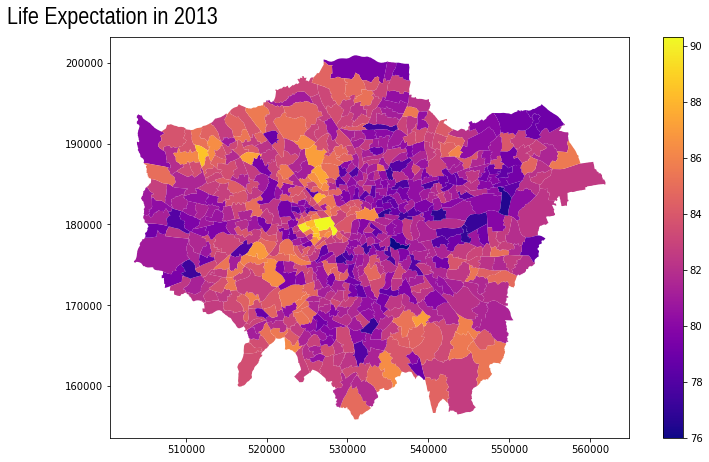

In [20]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
ppd.plot(column='Life_Expect', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"Life Expectation in 2013", x=0.025, size=24, **tfont);
#plt.savefig('Cluster_IMD_Score_Raw.png', dpi=150)

In [23]:
ppd = ppd[['NAME','GSS_CODE','geometry','Life_Expect','Child_Obesity','Incapacity_Benefit','Unemployment',
              'Crime','Deliberate_Fires','GCSE','PTA','Unauthorised_Absence','OS_Access']].copy()
ppd.head()

NAME   GSS_CODE  \
0       Chessington South  E05000405   
1  Tolworth and Hook Rise  E05000414   
2              Berrylands  E05000401   
3               Alexandra  E05000400   
4                Beverley  E05000402   

                                            geometry  Life_Expect  \
0  POLYGON ((516401.600 160201.800, 516407.300 16...         83.5   
1  POLYGON ((517829.600 165447.100, 517837.100 16...         83.5   
2  POLYGON ((518107.500 167303.400, 518114.300 16...         81.2   
3  POLYGON ((520480.000 166909.800, 520490.700 16...         85.2   
4  POLYGON ((522071.000 168144.900, 522063.900 16...         81.3   

   Child_Obesity  Incapacity_Benefit  Unemployment  Crime  Deliberate_Fires  \
0           22.6                 1.0           2.1   47.1               0.2   
1           17.3                 0.6           2.6   46.4               0.4   
2            8.3                 1.1           2.3   36.2               0.2   
3           16.9                 0.6           2.1   43.9               0.2   
4           15.8                 1.4           2.9   67.8               0.5   

    GCSE  PTA  Unauthorised_Absence  OS_Access  
0  335.0  2.4                  0.77       15.7  
1  336.0  2.3                  0.70      -10.7  
2  344.0  2.8                  0.52       -3.0  
3  360.0  2.2                  0.42       -5.8  
4  373.0  2.8                  0.67        1.8

In [27]:
to_cluster = ppd[['GSS_CODE','Life_Expect','Child_Obesity','Incapacity_Benefit','Unemployment',
              'Crime','Deliberate_Fires','GCSE','PTA','Unauthorised_Absence','OS_Access']].set_index('GSS_CODE').copy()
to_cluster.head()

Life_Expect  Child_Obesity  Incapacity_Benefit  Unemployment  \
GSS_CODE                                                                  
E05000405         83.5           22.6                 1.0           2.1   
E05000414         83.5           17.3                 0.6           2.6   
E05000401         81.2            8.3                 1.1           2.3   
E05000400         85.2           16.9                 0.6           2.1   
E05000402         81.3           15.8                 1.4           2.9   

           Crime  Deliberate_Fires   GCSE  PTA  Unauthorised_Absence  \
GSS_CODE                                                               
E05000405   47.1               0.2  335.0  2.4                  0.77   
E05000414   46.4               0.4  336.0  2.3                  0.70   
E05000401   36.2               0.2  344.0  2.8                  0.52   
E05000400   43.9               0.2  360.0  2.2                  0.42   
E05000402   67.8               0.5  373.0  2.8                  0.67   

           OS_Access  
GSS_CODE              
E05000405       15.7  
E05000414      -10.7  
E05000401       -3.0  
E05000400       -5.8  
E05000402        1.8

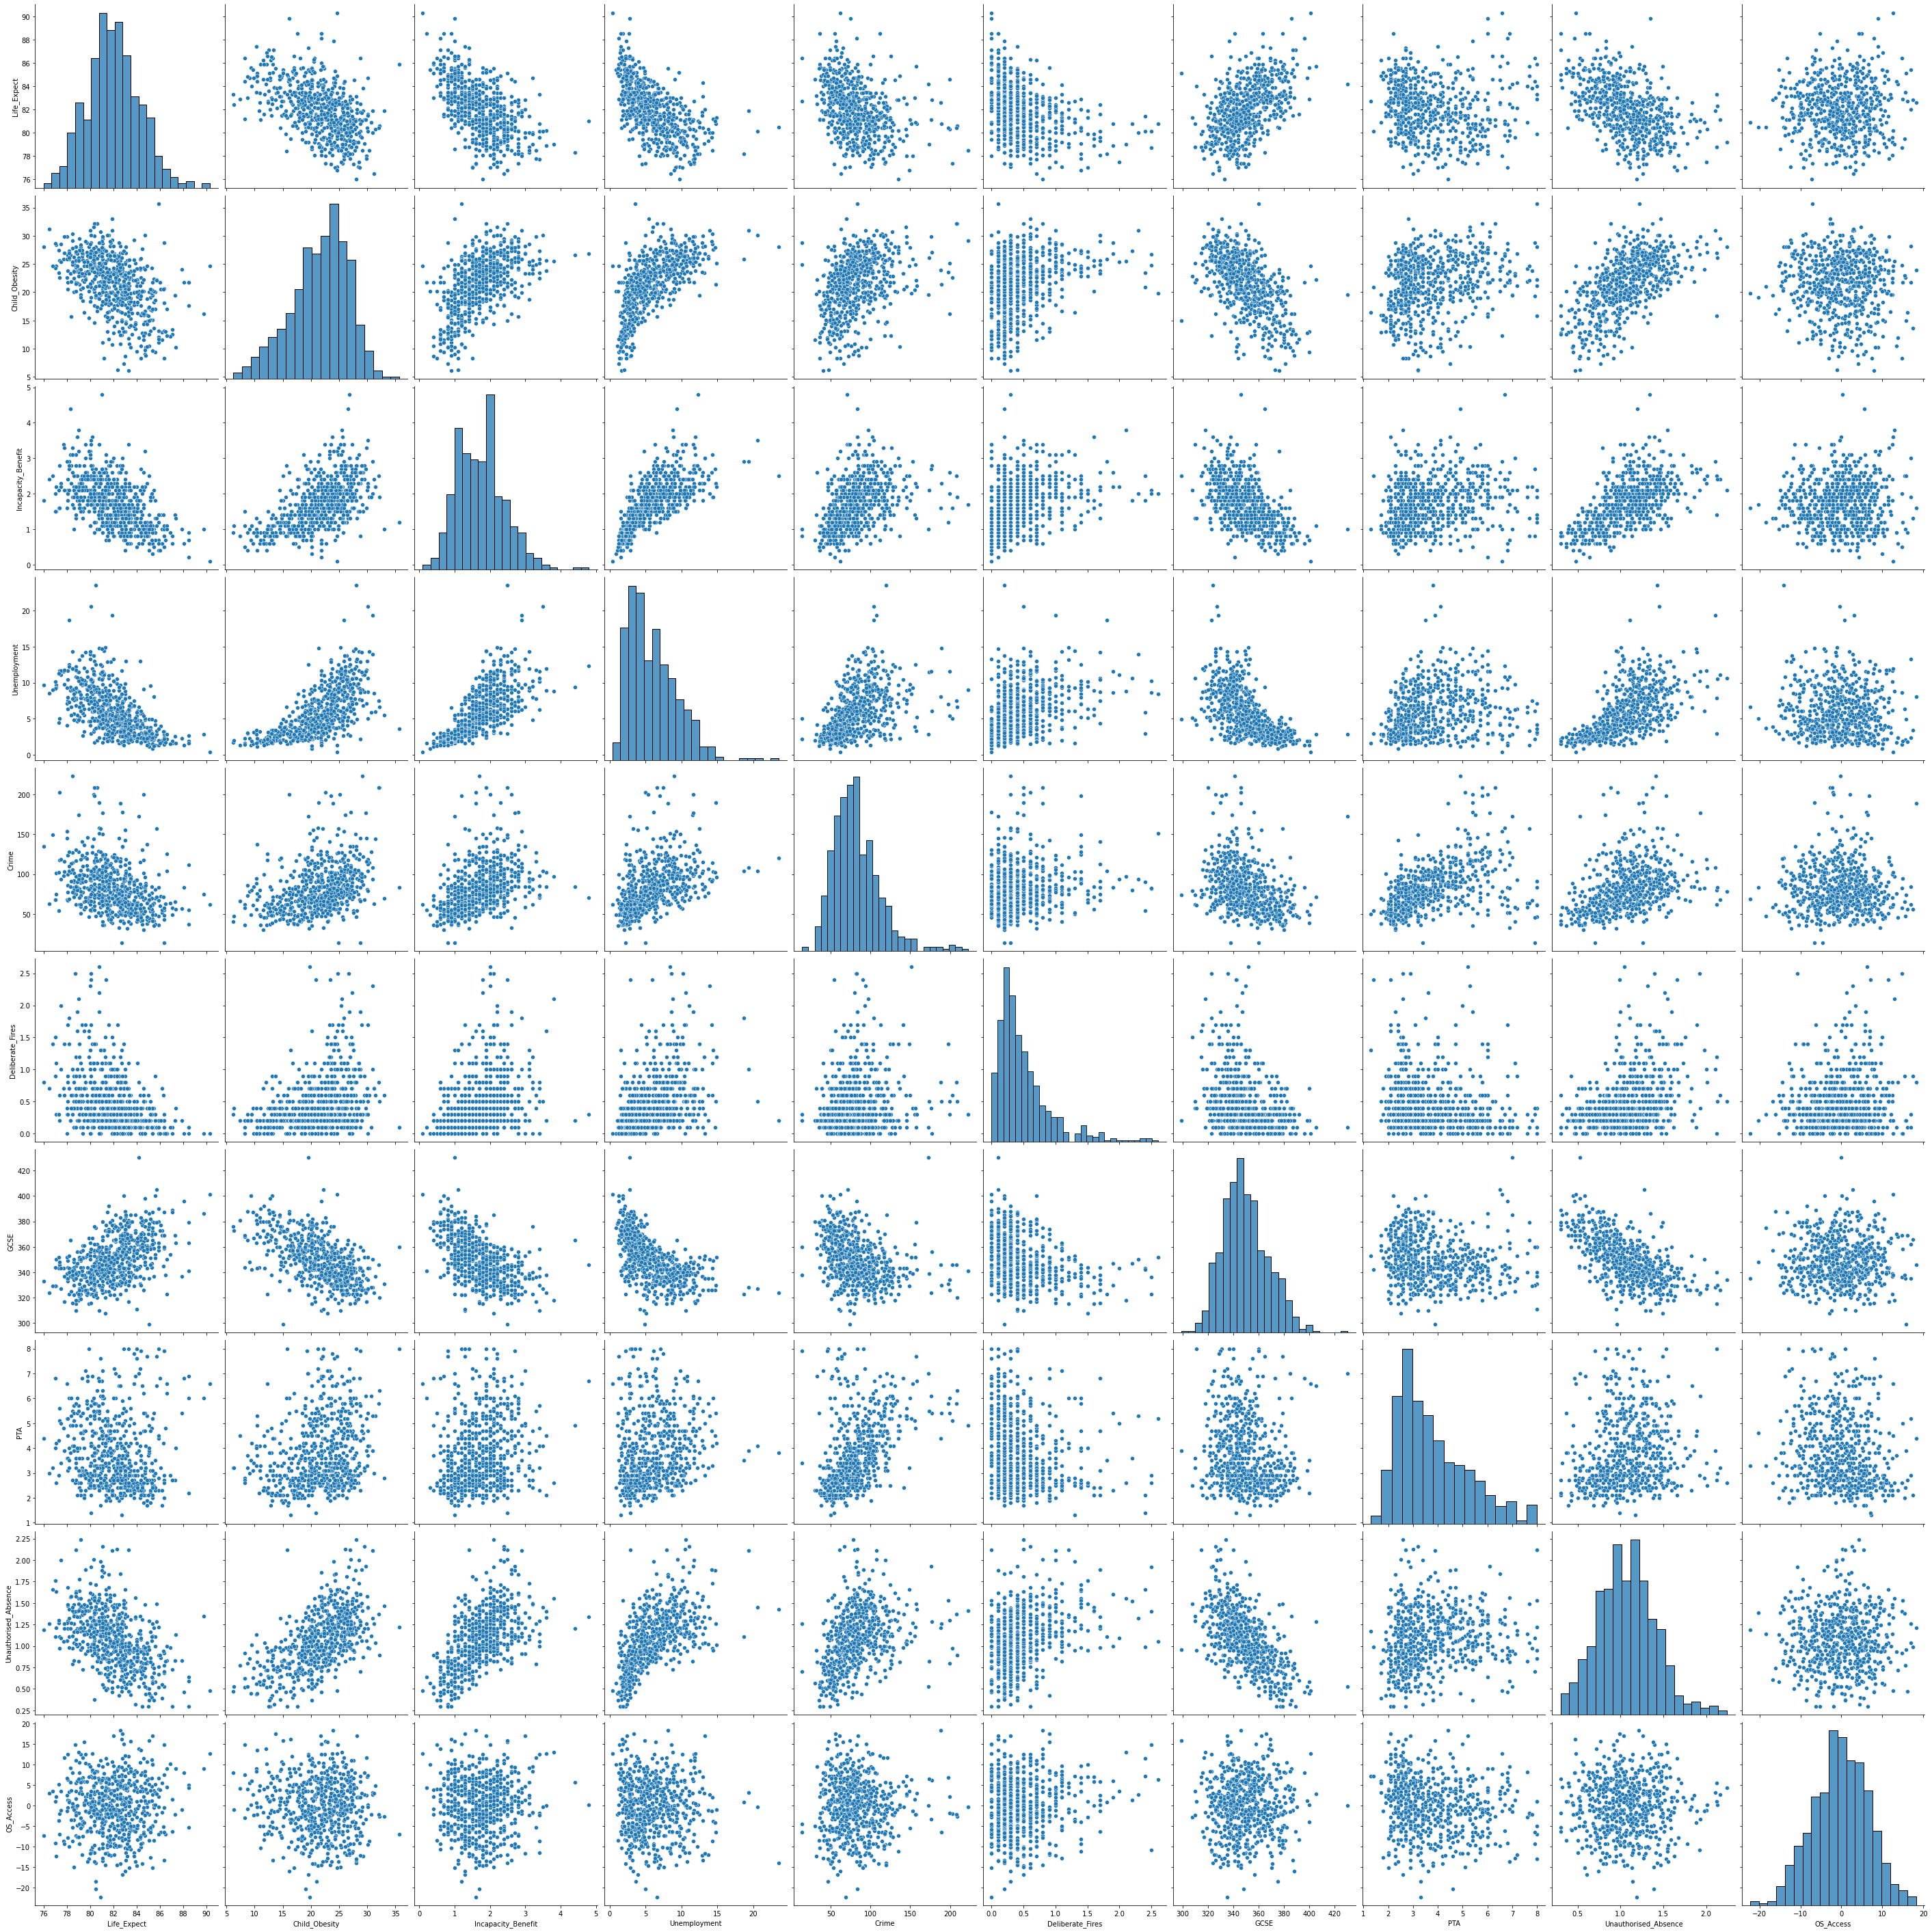

In [34]:
plot_norm = sns.pairplot(to_cluster,height = 4)

In [35]:
normed = to_cluster.copy()
for c in to_cluster.columns.values:
    normed[c] = rs.fit_transform(to_cluster[c].values.reshape(-1,1))
normed.sample(5)

Life_Expect  Child_Obesity  Incapacity_Benefit  Unemployment  \
GSS_CODE                                                                  
E05000481    -0.563140       0.031104            0.117647      0.454545   
E05000397     0.170648      -0.023328           -0.294118     -0.406699   
E05000648    -0.614334       0.349922            1.588235      0.490431   
E05000590    -0.409556      -0.015552            0.117647      0.598086   
E05000292     0.767918      -0.108865           -0.411765     -0.346890   

              Crime  Deliberate_Fires      GCSE       PTA  \
GSS_CODE                                                    
E05000481 -0.105644          0.444444 -0.307018  0.285714   
E05000397  0.235890         -0.444444  0.219298  0.457143   
E05000648  0.079595         -0.222222  0.372807  0.428571   
E05000590  0.068017          0.333333 -0.416667 -0.142857   
E05000292 -0.338640         -0.222222  0.460526 -0.200000   

           Unauthorised_Absence  OS_Access  
GSS_CODE                                    
E05000481              0.502392  -0.056497  
E05000397              0.562201   0.847458  
E05000648              0.167464   0.322034  
E05000590              0.502392   0.045198  
E05000292             -0.633971  -0.022599

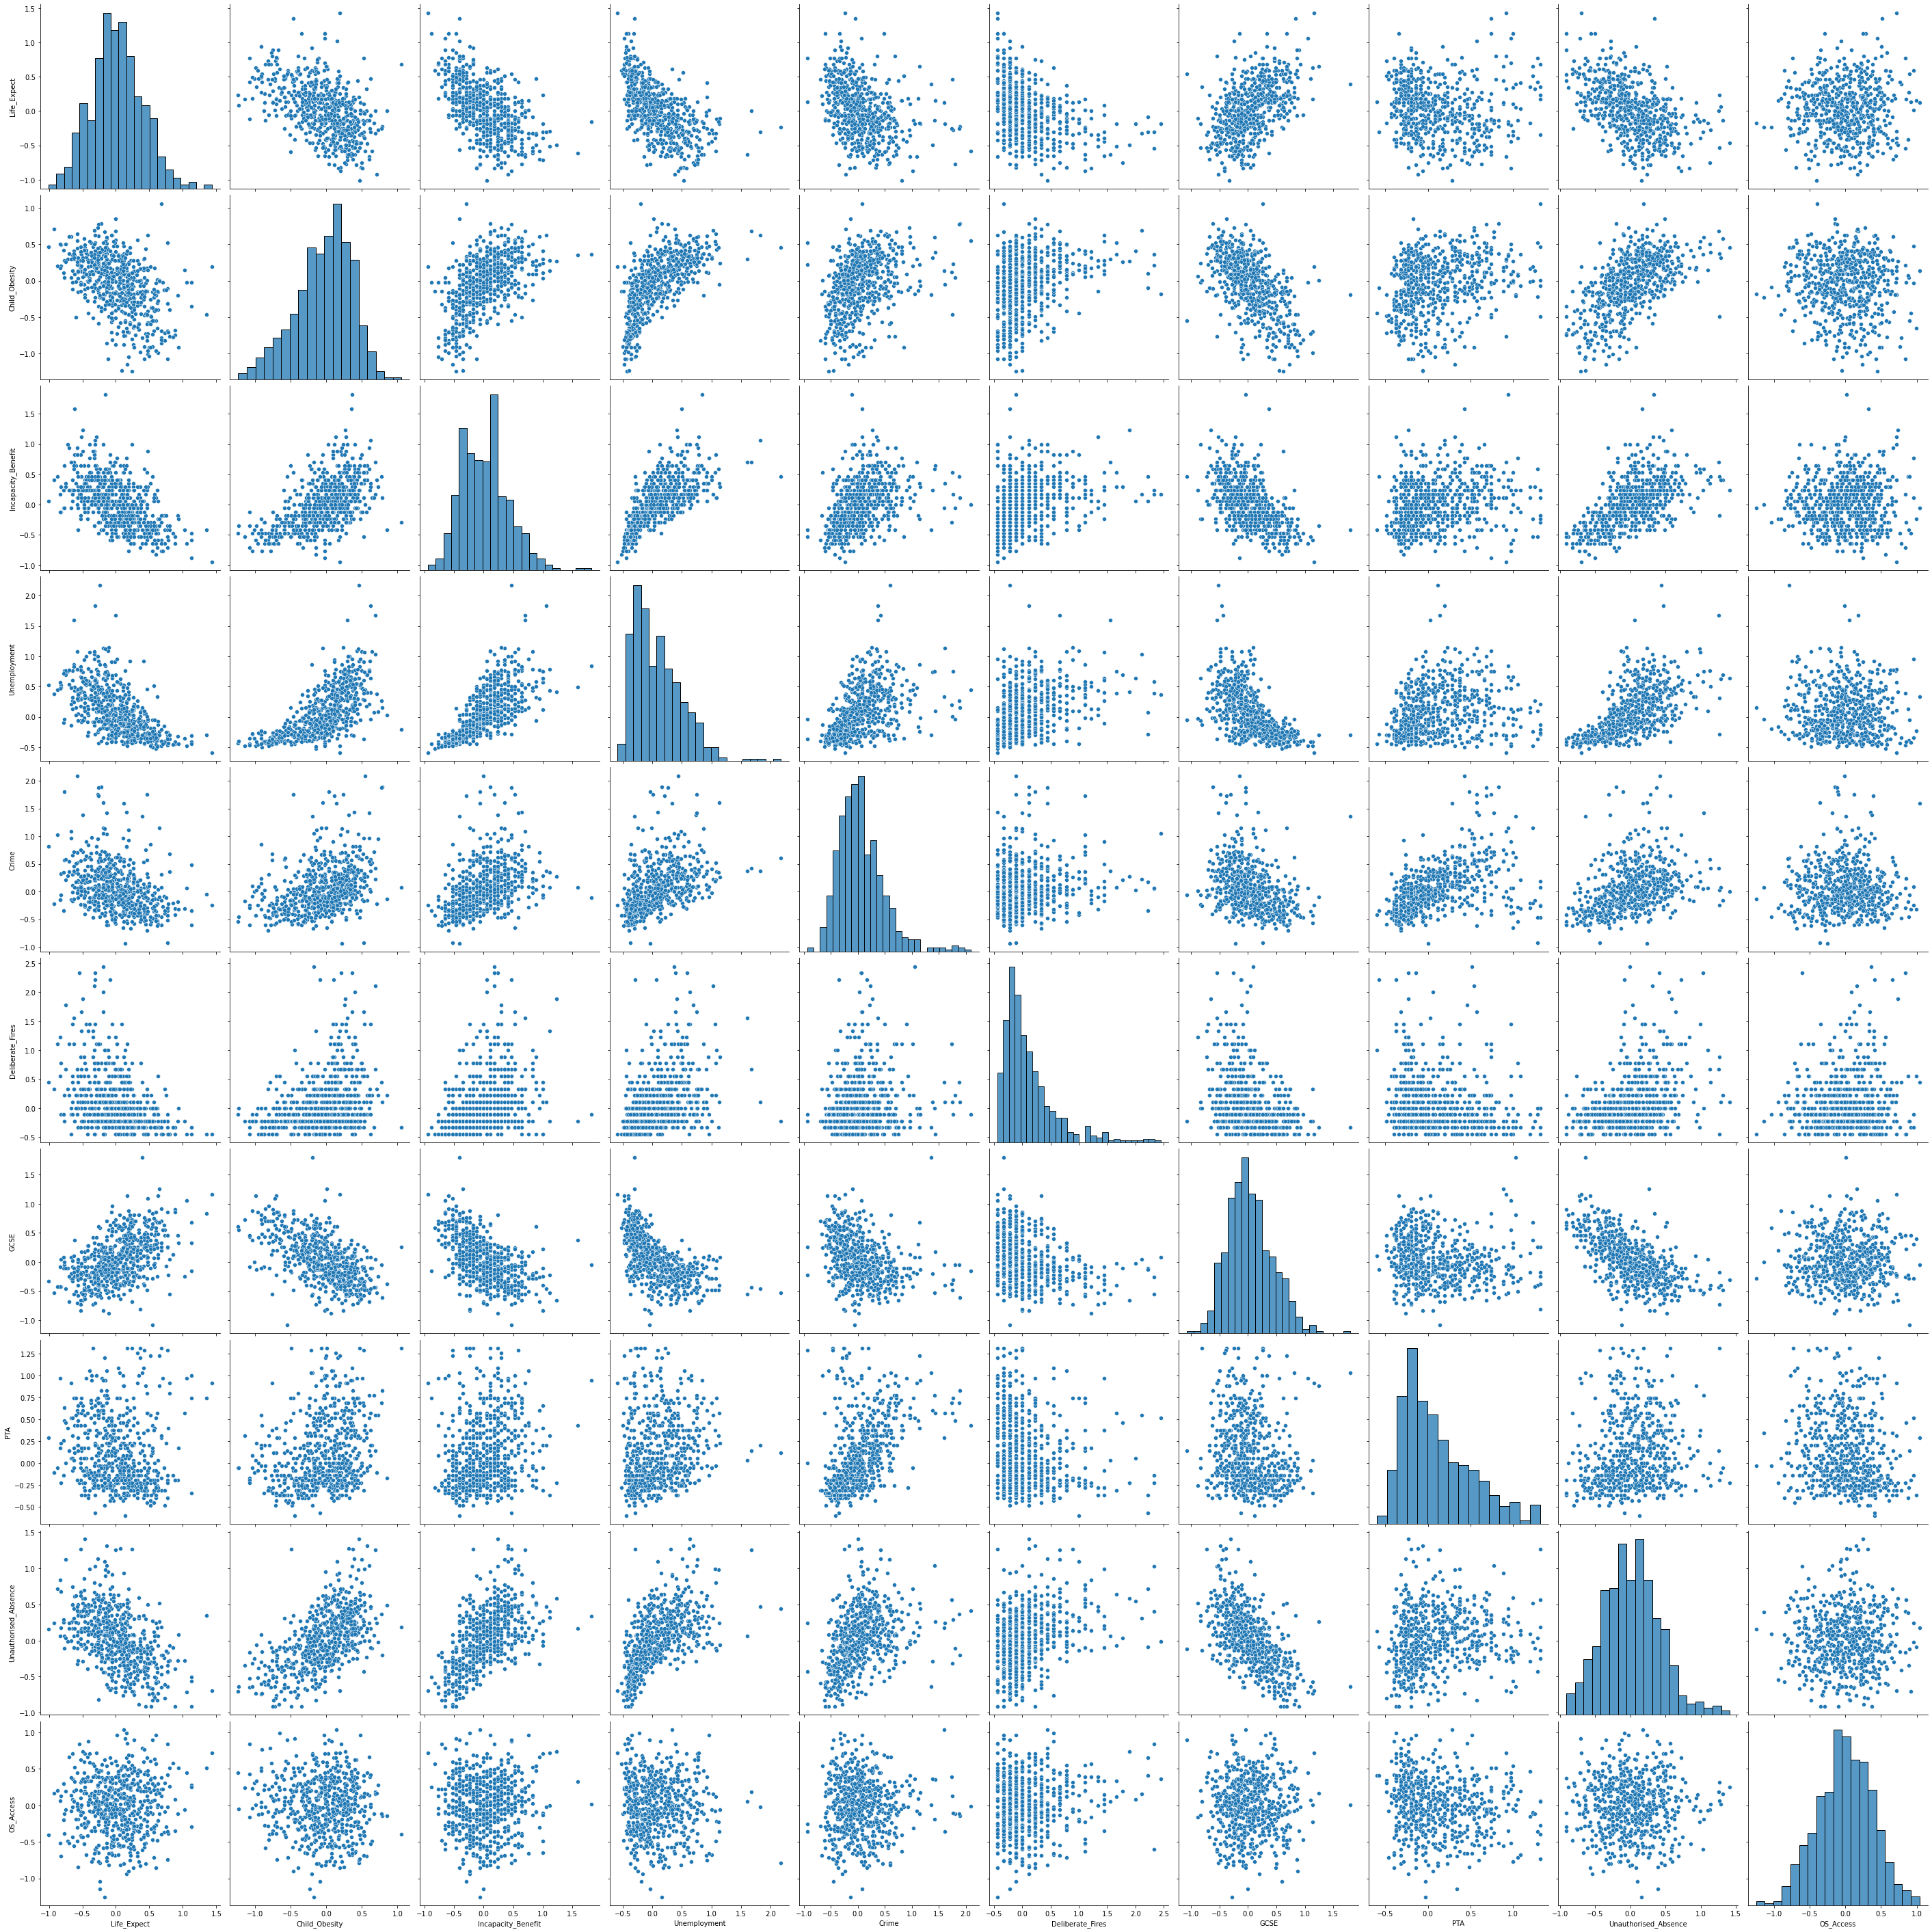

In [36]:
plot_norm = sns.pairplot(normed,height = 4)

In [37]:
rand_st_int = 10 
pca = PCA(random_state=rand_st_int)

normed_pca = pca.fit_transform(normed)
print('Explained variance ratio of each component:')
print(pca.explained_variance_ratio_)

Explained variance ratio of each component:
[0.43811228 0.15453524 0.0882221  0.07893738 0.05684955 0.04771206
 0.0404896  0.03669763 0.03578129 0.02266288]


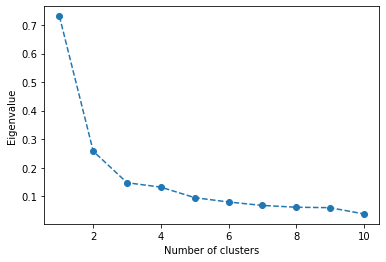

In [38]:
dfpc = pd.DataFrame({'eigenvalue':pca.explained_variance_,
             'PC':list(range(1, pca.n_components_ + 1))})

plt.plot(dfpc['PC'], dfpc['eigenvalue'], marker='o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('Eigenvalue')
plt.show()

In [58]:
pca = PCA(n_components = 2)

normed_pca = pca.fit_transform(normed)
print('Explained variance ratio of each component:')
print(pca.explained_variance_ratio_)

Explained variance ratio of each component:
[0.43811228 0.15453524]


In [59]:
list_var = normed.columns.tolist()
print(list_var)

['Life_Expect', 'Child_Obesity', 'Incapacity_Benefit', 'Unemployment', 'Crime', 'Deliberate_Fires', 'GCSE', 'PTA', 'Unauthorised_Absence', 'OS_Access']


In [60]:
df_PrincipleComp = pd.DataFrame(pca.components_, columns = list_var)
df_PrincipleComp

Life_Expect  Child_Obesity  Incapacity_Benefit  Unemployment     Crime  \
0    -0.333682       0.357671            0.372267      0.407061  0.299835   
1    -0.083230      -0.065967           -0.029409     -0.015834 -0.398289   

   Deliberate_Fires      GCSE       PTA  Unauthorised_Absence  OS_Access  
0          0.299540 -0.345597  0.132228              0.373981  -0.006161  
1          0.646885 -0.022858 -0.588441              0.027605   0.250927

In [61]:
score_pca = pca.transform(normed)
score_pca

array([[-0.73335588,  0.44894409],
       [-0.91396394,  0.26962685],
       [-1.17419542,  0.27056272],
       ...,
       [ 1.39448325,  1.27893656],
       [ 0.97470514,  0.68342218],
       [-0.88059335, -0.61237361]])

In [62]:
print('Eigenvalues of each component:')
print(pca.explained_variance_)

Eigenvalues of each component:
[0.7309995  0.25784528]


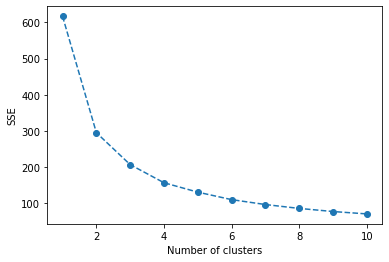

In [63]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='k-means++', random_state=0)
    km.fit(score_pca)
    # inertia is a concept in physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [73]:
k_cluster = 3
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(score_pca)

KMeans(n_clusters=3, random_state=1)

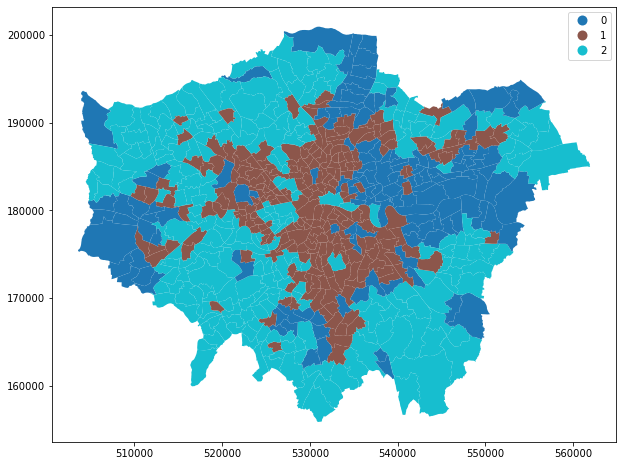

In [74]:
ppd['Kmeans_Cluster'] = kmeans_method.labels_
ppd.plot(column='Kmeans_Cluster', categorical=True, legend=True, figsize=(12,8));

In [75]:
ppd_kpca = pd.concat([ppd.reset_index(drop = True), pd.DataFrame(score_pca)],axis = 1)
ppd_kpca.columns.values[-2: ] = ['Component1','Component2']

In [76]:
ppd_kpca['Segement'] = ppd_kpca['Kmeans_Cluster'].map({0:'First',1:'Second',2:'Third',3:'Forth'})

In [77]:
ppd_kpca.head()

NAME   GSS_CODE  \
0       Chessington South  E05000405   
1  Tolworth and Hook Rise  E05000414   
2              Berrylands  E05000401   
3               Alexandra  E05000400   
4                Beverley  E05000402   

                                            geometry  Life_Expect  \
0  POLYGON ((516401.600 160201.800, 516407.300 16...         83.5   
1  POLYGON ((517829.600 165447.100, 517837.100 16...         83.5   
2  POLYGON ((518107.500 167303.400, 518114.300 16...         81.2   
3  POLYGON ((520480.000 166909.800, 520490.700 16...         85.2   
4  POLYGON ((522071.000 168144.900, 522063.900 16...         81.3   

   Child_Obesity  Incapacity_Benefit  Unemployment  Crime  Deliberate_Fires  \
0           22.6                 1.0           2.1   47.1               0.2   
1           17.3                 0.6           2.6   46.4               0.4   
2            8.3                 1.1           2.3   36.2               0.2   
3           16.9                 0.6           2.1   43.9               0.2   
4           15.8                 1.4           2.9   67.8               0.5   

    GCSE  PTA  Unauthorised_Absence  OS_Access  Kmeans_Cluster  Component1  \
0  335.0  2.4                  0.77       15.7               2   -0.733356   
1  336.0  2.3                  0.70      -10.7               2   -0.913964   
2  344.0  2.8                  0.52       -3.0               2   -1.174195   
3  360.0  2.2                  0.42       -5.8               2   -1.436283   
4  373.0  2.8                  0.67        1.8               2   -0.793779   

   Component2 Segement  
0    0.448944    Third  
1    0.269627    Third  
2    0.270563    Third  
3    0.184141    Third  
4    0.316296    Third

/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


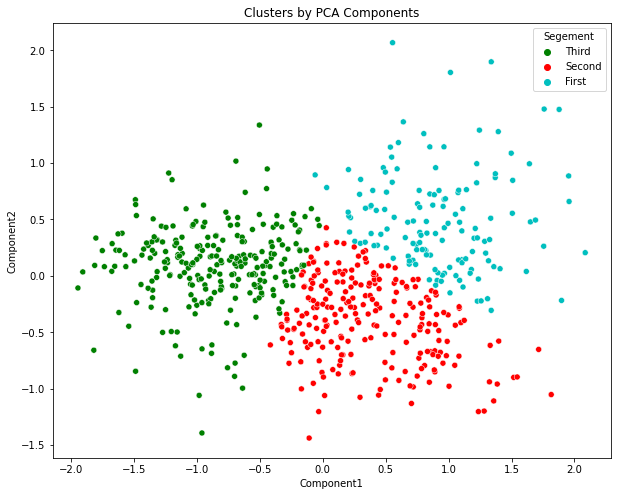

In [78]:
x_axis = ppd_kpca['Component1']
y_axis = ppd_kpca['Component2']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis,y_axis,hue = ppd_kpca['Segement'], palette = ['g','r','c'])
plt.title('Clusters by PCA Components')
plt.show()